### Welcome!
Hey there, this notebook was created to accompany the [Udacity Self Driving Car - Behavioural Cloning dataset.](https://www.kaggle.com/datasets/andy8744/udacity-self-driving-car-behavioural-cloning/)

A tutorial will be provided in how to run inference the model in [Udacity's self driving car sim.](https://github.com/udacity/self-driving-car-sim)

This project shows how to do behavioral cloning. The model only uses a simple convolutional neural network to do image regression. 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil

### 1. Loading in training data
Our model will be simple and will only use the front camera to produce a steering angle. Throttle will be set to max.
This example will only train on track 1 (lake track)

In [3]:
src = "../input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make"
dest = "./dataset"
shutil.copytree(src, dest)

'./dataset'

In [4]:
train_df = pd.read_csv("./dataset/driving_log.csv",
                       names=["center_cam", "left_cam", "right_cam", "steering_angle", "throttle", "reverse", "speed"])
train_df = train_df[["center_cam", "steering_angle"]] # do not need other values 
train_df.head()

,center_cam,steering_angle
0,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
1,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
2,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
3,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
4,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0


We need to extract the filename from original path

In [5]:
train_df["center_cam"][0].split("\\")[-1]

'center_2022_04_10_12_24_41_840.jpg'

In [6]:
train_df["center_cam"] = train_df["center_cam"].apply(lambda x: x.split("\\")[-1])
train_df.head()

,center_cam,steering_angle
0,center_2022_04_10_12_24_41_840.jpg,0.0
1,center_2022_04_10_12_24_41_908.jpg,0.0
2,center_2022_04_10_12_24_41_976.jpg,0.0
3,center_2022_04_10_12_24_42_044.jpg,0.0
4,center_2022_04_10_12_24_42_116.jpg,0.0


#### Data visualization

There is severe imabalance in data. The class for a steering of 0 is over-represented; also there is more negative than positive values. To solve this, we can undersample the over-represented class by or oversampling the under-represented class. 

As we have more negative values than positive values, we can either collect more data for positive values - or alternatively do some image augmentation. We can flip the images horizontally and invert the steering angle. 

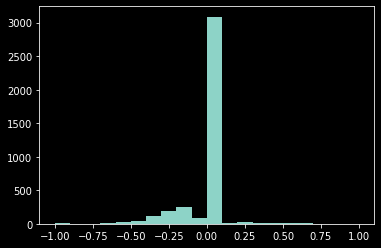

In [7]:
plt.hist(train_df.steering_angle.values, bins=20);

In [8]:
train_df.steering_angle.describe()

count    3930.000000
mean       -0.034529
std         0.133405
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering_angle, dtype: float64

### 2. Data Balancing 

Values that have steering angles that are not 0

In [9]:
non_zero_df = train_df[train_df["steering_angle"] != 0.0]
non_zero_df

,center_cam,steering_angle
6,center_2022_04_10_12_24_42_256.jpg,-0.05
7,center_2022_04_10_12_24_42_324.jpg,-0.20
8,center_2022_04_10_12_24_42_393.jpg,-0.35
9,center_2022_04_10_12_24_42_463.jpg,-0.55
10,center_2022_04_10_12_24_42_531.jpg,-0.70
...,...,...
3863,center_2022_04_10_12_29_10_622.jpg,-0.20
3869,center_2022_04_10_12_29_11_052.jpg,-0.15
3870,center_2022_04_10_12_29_11_126.jpg,-0.35
3895,center_2022_04_10_12_29_12_873.jpg,-0.15


#### Steering angle inversion data augmentation
We need to create a function that does the following:
1. Take as input image name, location of images, steering angle
2. Read image and do a horizontal flip
3. Invert steering angle
4. Return new image (add flipped) and new angle 


In [10]:
# only use the center cam
img_names = train_df[train_df["steering_angle"] < 0].center_cam.values
img_names[:5]

array(['center_2022_04_10_12_24_42_256.jpg',
       'center_2022_04_10_12_24_42_324.jpg',
       'center_2022_04_10_12_24_42_393.jpg',
       'center_2022_04_10_12_24_42_463.jpg',
       'center_2022_04_10_12_24_42_531.jpg'], dtype=object)

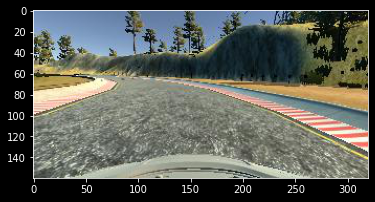

In [11]:
img_dir = "./dataset/IMG"
img_path = os.path.join(img_dir, img_names[0])
img = plt.imread(img_path)
plt.imshow(img);

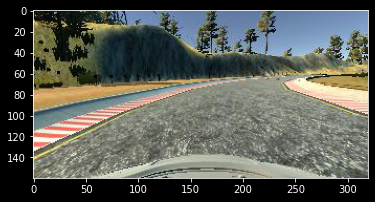

In [12]:
plt.imshow(cv2.flip(img, 1))

In [14]:
def augment_data(img_dir, img_name, label):
    img_path = os.path.join(img_dir, img_name)
    img = plt.imread(img_path)
    return (cv2.flip(img, 1), (-label))

Testing of function - seems to work good

0.5


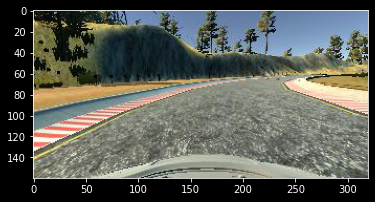

In [15]:
flipped_img, new_label = augment_data(img_dir, img_names[0], -0.5)
plt.imshow(flipped_img);
print(new_label)

Now we need the function to save the file in the same directory, with a new file name - instead of returning the image, the filename is returned

In [16]:
def augment_and_save(img_dir, img_name, label):
    img_path = os.path.join(img_dir, img_name)
    img = plt.imread(img_path)
    new_img_name = img_name.replace(".jpg", "") + "_flipped.jpg"
    new_img_path = os.path.join(img_dir, new_img_name)
    cv2.imwrite(new_img_path, cv2.flip(img, 1))
    return (new_img_name, (-label))

Apply function to our non-zero steering angles

In [17]:
images = []
labels = []

img_dir = "./dataset/IMG"

for index, data in non_zero_df.iterrows():
    image, label = augment_and_save(img_dir, data["center_cam"],  data["steering_angle"])
    images.append(image)
    labels.append(label)

0.05


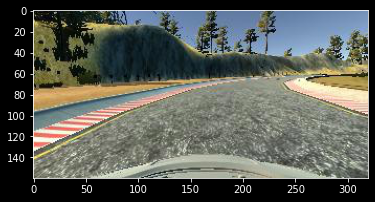

In [18]:
img_path = os.path.join(img_dir, images[0])
img = plt.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
print(labels[0])

In [20]:
augmented_df = pd.DataFrame(list(zip(images, labels)), columns=["center_cam", "steering_angle"])

#### Dropping random zero values

We will only take 5% of the original dataset of steering angle of 0

In [21]:
zero_df = train_df.query("steering_angle == 0.0").sample(frac=.05)
len(zero_df)

153

#### New Dataframe


In [22]:
new_train_df = pd.concat([zero_df, augmented_df, non_zero_df])
new_train_df.head()

,center_cam,steering_angle
723,center_2022_04_10_12_25_32_316.jpg,0.0
2225,center_2022_04_10_12_27_16_829.jpg,0.0
2786,center_2022_04_10_12_27_55_829.jpg,0.0
3284,center_2022_04_10_12_28_30_370.jpg,0.0
3424,center_2022_04_10_12_28_40_160.jpg,0.0


In [23]:
len(new_train_df)

1891

##### Visualization
Now the left and right is a lot more balanced. The distribution is gaussian - equal distribution is preferred. 

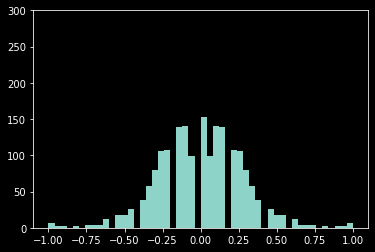

In [24]:
plt.ylim(0, 300)
plt.hist(new_train_df.steering_angle.values, bins=50);

### Preparing Data for Model

In [25]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(validation_split=0.2)

In [27]:
train_generator=datagen.flow_from_dataframe(
  dataframe=new_train_df,
  directory="./dataset/IMG",
  x_col="center_cam",
  y_col="steering_angle",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)

valid_generator=datagen.flow_from_dataframe(
  dataframe=new_train_df,
  directory="./dataset/IMG",
  x_col="center_cam",
  y_col="steering_angle",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)

Found 1513 validated image filenames.
Found 378 validated image filenames.


### Create Model and train
The model will be created with a simple VGG like network.

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(0.5),
    ]
)

2022-12-06 02:50:28.335994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 02:50:28.423675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 02:50:28.424572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 02:50:28.426845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
model = tf.keras.Sequential([
    layers.Input(shape=(160, 320, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [42]:
model.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(),
)

history = model.fit(train_generator, epochs=50,
          validation_data=valid_generator)

Epoch 1/50
48/48 [==============================] - 5s 86ms/step - loss: 0.0474 - val_loss: 0.1359
Epoch 2/50
48/48 [==============================] - 4s 80ms/step - loss: 0.0439 - val_loss: 0.1212
Epoch 3/50
48/48 [==============================] - 4s 73ms/step - loss: 0.0438 - val_loss: 0.1428
Epoch 4/50
48/48 [==============================] - 4s 79ms/step - loss: 0.0429 - val_loss: 0.1405
Epoch 5/50
48/48 [==============================] - 4s 79ms/step - loss: 0.0452 - val_loss: 0.1253
Epoch 6/50
48/48 [==============================] - 4s 74ms/step - loss: 0.0440 - val_loss: 0.1233
Epoch 7/50
48/48 [==============================] - 3s 72ms/step - loss: 0.0481 - val_loss: 0.1400
Epoch 8/50
48/48 [==============================] - 4s 78ms/step - loss: 0.0406 - val_loss: 0.1218
Epoch 9/50
48/48 [==============================] - 4s 74ms/step - loss: 0.0391 - val_loss: 0.1302
Epoch 10/50
48/48 [==============================] - 4s 86ms/step - loss: 0.0420 - val_loss: 0.1338
Epoch 11/

In [43]:
model.history.history

{'loss': [0.04735326021909714,
  0.043932121247053146,
  0.04383596032857895,
  0.04292285814881325,
  0.04521487280726433,
  0.044043269008398056,
  0.048134468495845795,
  0.04063982889056206,
  0.03907735273241997,
  0.042005665600299835,
  0.04513298720121384,
  0.04395274445414543,
  0.041208505630493164,
  0.040924713015556335,
  0.03854648768901825,
  0.041821010410785675,
  0.04058316349983215,
  0.03741529956459999,
  0.040473658591508865,
  0.035632673650979996,
  0.03653905540704727,
  0.03822247311472893,
  0.03730105236172676,
  0.03443238511681557,
  0.03422847390174866,
  0.035288017243146896,
  0.036070890724658966,
  0.03517458587884903,
  0.03642522916197777,
  0.03395912051200867,
  0.03719065710902214,
  0.03390028327703476,
  0.03936922922730446,
  0.03609571233391762,
  0.03505714237689972,
  0.03551997244358063,
  0.03453531116247177,
  0.03558773919939995,
  0.03419487923383713,
  0.0364363007247448,
  0.035319942981004715,
  0.03382430225610733,
  0.03225647658

### Test Inference and Save Model

In [33]:
img.shape

(160, 320, 3)

In [34]:
np.squeeze(model.predict(tf.expand_dims(img, axis=0)))

array(0.35140148, dtype=float32)

In [36]:
model.save("./self_driving_model")

### Conclusion

After reducing the number of images with steering angle = 0, we only end up with around 1800 images. The model can be improved with hyperparameter tuning and addition of a learning rate scheduler. Transfer learning may improve model performance as we have very little training images. 

We can also combine the training data from the second track. 